In [50]:

%matplotlib inline
import matplotlib.pyplot as plt
import scipy.io as sio
import math
import numpy as np
from scipy.signal import butter, lfilter, filtfilt, medfilt

matlab_file = './Sushant_CSI/1m/backward_converted/log_2.mat'
plt.rcParams['figure.dpi'] = 275


SyntaxError: unexpected EOF while parsing (<ipython-input-50-864b0a059b0f>, line 12)

In [51]:
# Load matlab file containing Amplitude domain CSI data

mat_contents = sio.loadmat(matlab_file)
antenna = mat_contents['M']
subcarrier = 89   # Selected Subcarrier
fs = 0.05        # Sampling Frequency
flt_ord = 12     # Filter order number

# Create list of CSI stream of one subcarrier
x_axis = []
y_axis = []
for i in range(0, len(antenna)):
    x_axis.append(i)
    y_axis.append(antenna_1[i][subcarrier])

IndentationError: unexpected indent (<ipython-input-51-1361c06eca92>, line 2)

Text(0.5, 1.0, 'Raw CSI stream')

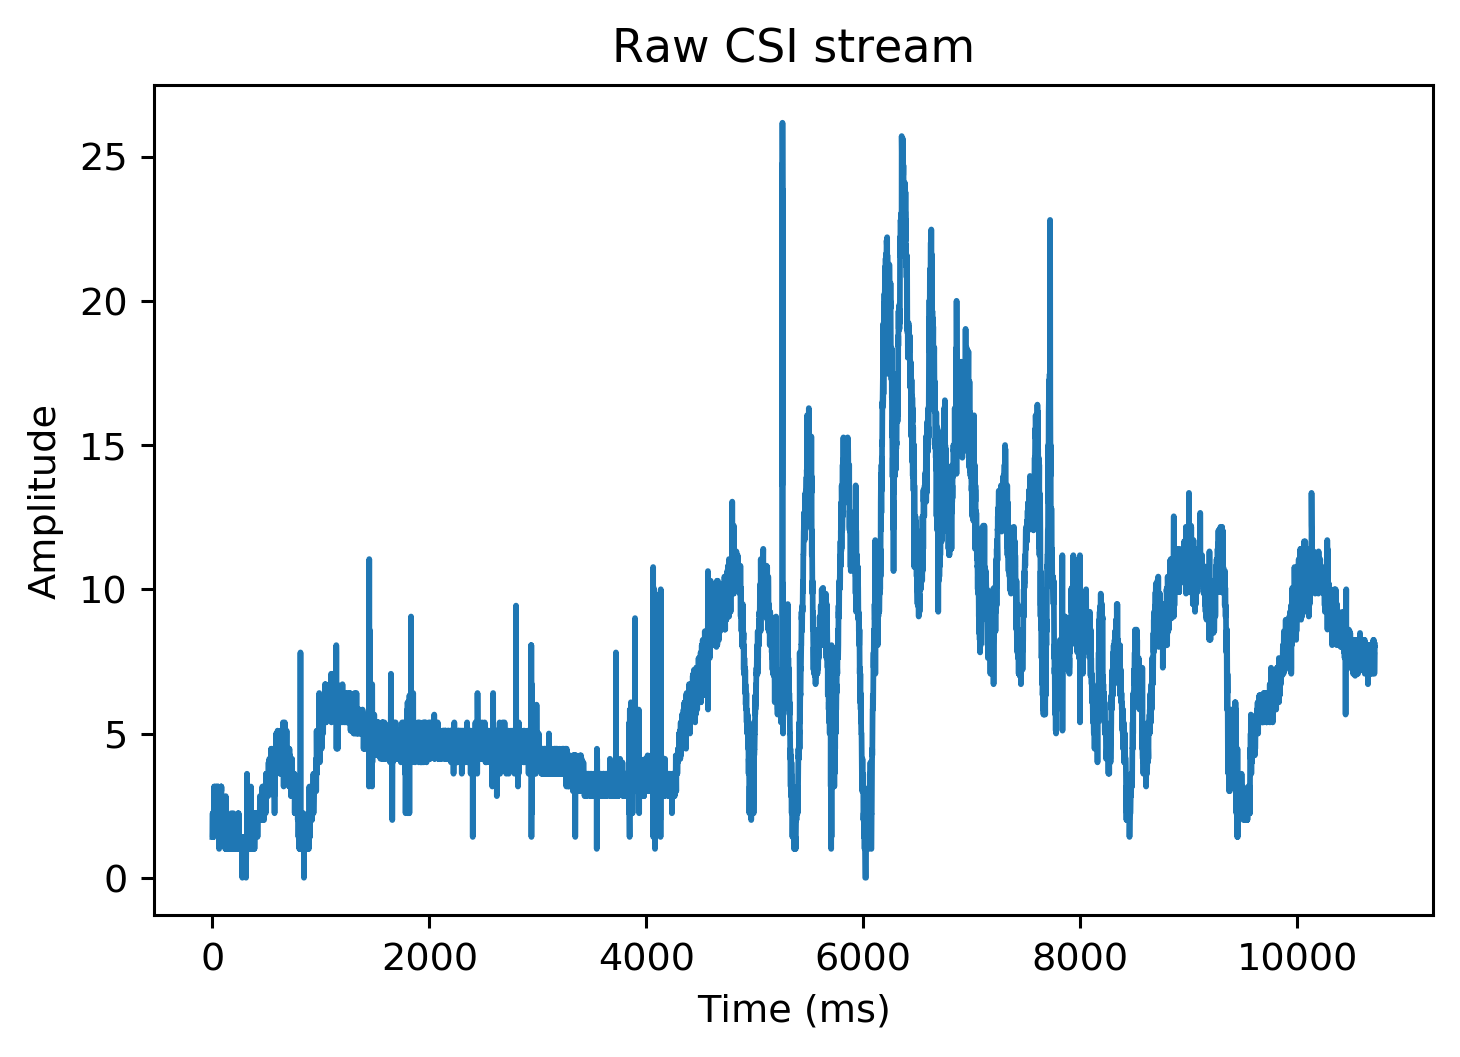

In [36]:
plt.plot(y_axis)
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.title('Raw CSI stream')

Text(0.5, 1.0, 'Filtered CSI stream (Ord 12)')

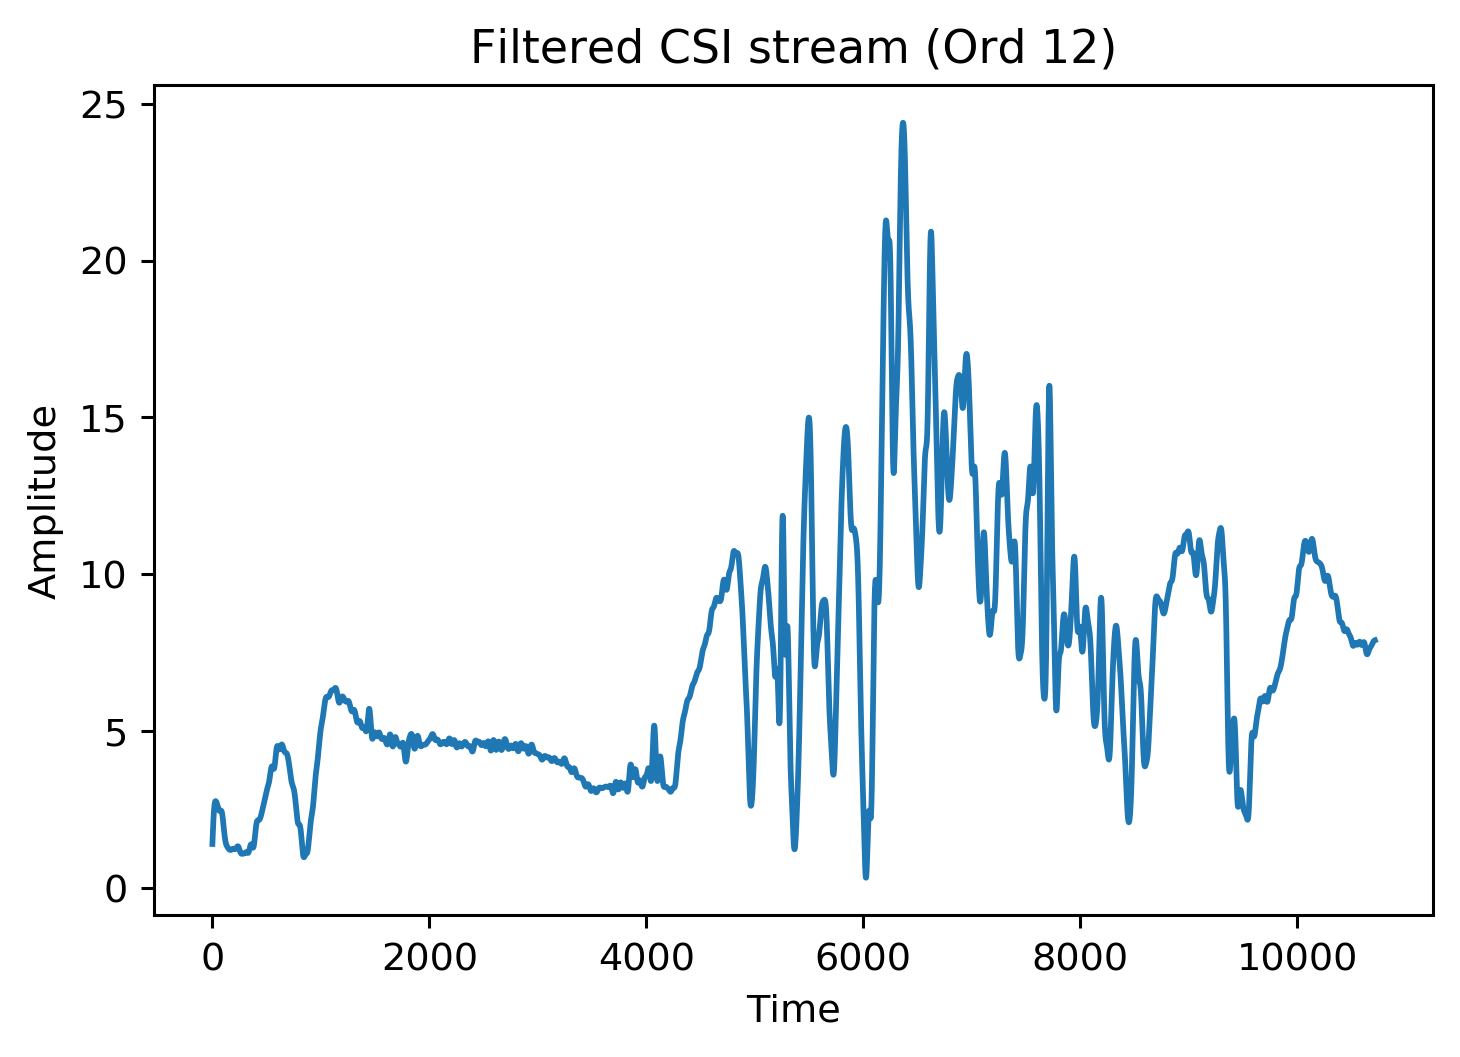

In [37]:
flt_ord = 12
b, a = butter(flt_ord, 0.05, 'lowpass', analog=False)
output = filtfilt(b, a, y_axis)
plt.plot(output)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Filtered CSI stream (Ord 12)')

In [38]:
# flt_ord = 5
# b, a = butter(flt_ord, 30/(fs/2), 'lowpass', analog=False)
# output = filtfilt(b, a, y_axis)
# plt.plot(output)
# plt.xlabel('Time')
# plt.ylabel('Amplitude')
# plt.title('Filtered CSI stream (Ord 5)')

In [39]:
# -- SILENCE REMOVAL ---
import math

# Separate the CSI data into a sequence of frames
num_packets = len(output)

# 50 ms is the number of data(frequency) in each frame.

data_per_frame = 50
total_num_frames = math.floor(num_packets/data_per_frame) 

frames = []
for frame in range(total_num_frames):
    cur_index = data_per_frame*frame
    seq = output[cur_index : cur_index+data_per_frame]
    frames.append(seq)
    

In [40]:
# Calculate energy for each frame
# Energy each frame = Average of the Squares for each frame
energy = []
for frame in frames:
    sq_sum = sum(map(lambda x: x*x, frame))
    e_frame = sq_sum/data_per_frame
    energy.append(e_frame)

In [41]:
# Apply median filter to energy values and take their log
filt_energy = medfilt(energy)
filt_energy = [math.log(e) for e in filt_energy]

In [42]:
# Select contiguous block of frames s_mid for which energy > mean energy

# Get indices for which energy > mean energy
curr_index = 0
high_energy_indices = []
mean_energy = sum(filt_energy)/len(filt_energy)
for energy in filt_energy:
    if energy > mean_energy:
        high_energy_indices.append(curr_index)
    curr_index += 1;

# Split the high energy indices into contigious subsequences
curr_index = None
inside_arr = []
conti_arr = []
for index in high_energy_indices:
    if (curr_index is None):
        inside_arr.append(index)
    else:
        if (curr_index == index-1):
            inside_arr.append(index)
        else:
            conti_arr.append(inside_arr)
            inside_arr = []
            inside_arr.append(index)
    
    curr_index = index

if inside_arr:
    conti_arr.append(inside_arr)

# Select the longest contigious subsequence
s_mid = max(conti_arr, key=len)

# Get the corresponding CSI data frames h_mid for s_mid
h_mid = []
for index in s_mid:
    h_mid.append(frames[index])
        

In [43]:
# Calculate the midpoint of the region h_mid which has maximum
# deviations from the average in h_mid

high_energy_csi = [item for sublist in h_mid for item in sublist]
avg_energy = sum(high_energy_csi)/len(high_energy_csi)

max_dev = 0
max_dev_index = 0
for index, energy in enumerate(high_energy_csi):
    deviation = abs(avg_energy - energy)
    if deviation > max_dev:
        max_dev = deviation
        max_dev_index = index
        
m = s_mid[0] * data_per_frame + max_dev_index 

In [44]:
# Set start_point to m−T/2, where T is total duration
start_point = math.floor(m - (num_packets)/2)
start_point = max(start_point, 0)

# Set end_point to m+T/2, where T is total duration
end_point = math.floor(m + (num_packets)/2)
end_point = min(end_point, num_packets)

Text(0.5, 1.0, 'Filtered CSI stream (Ord 12)')

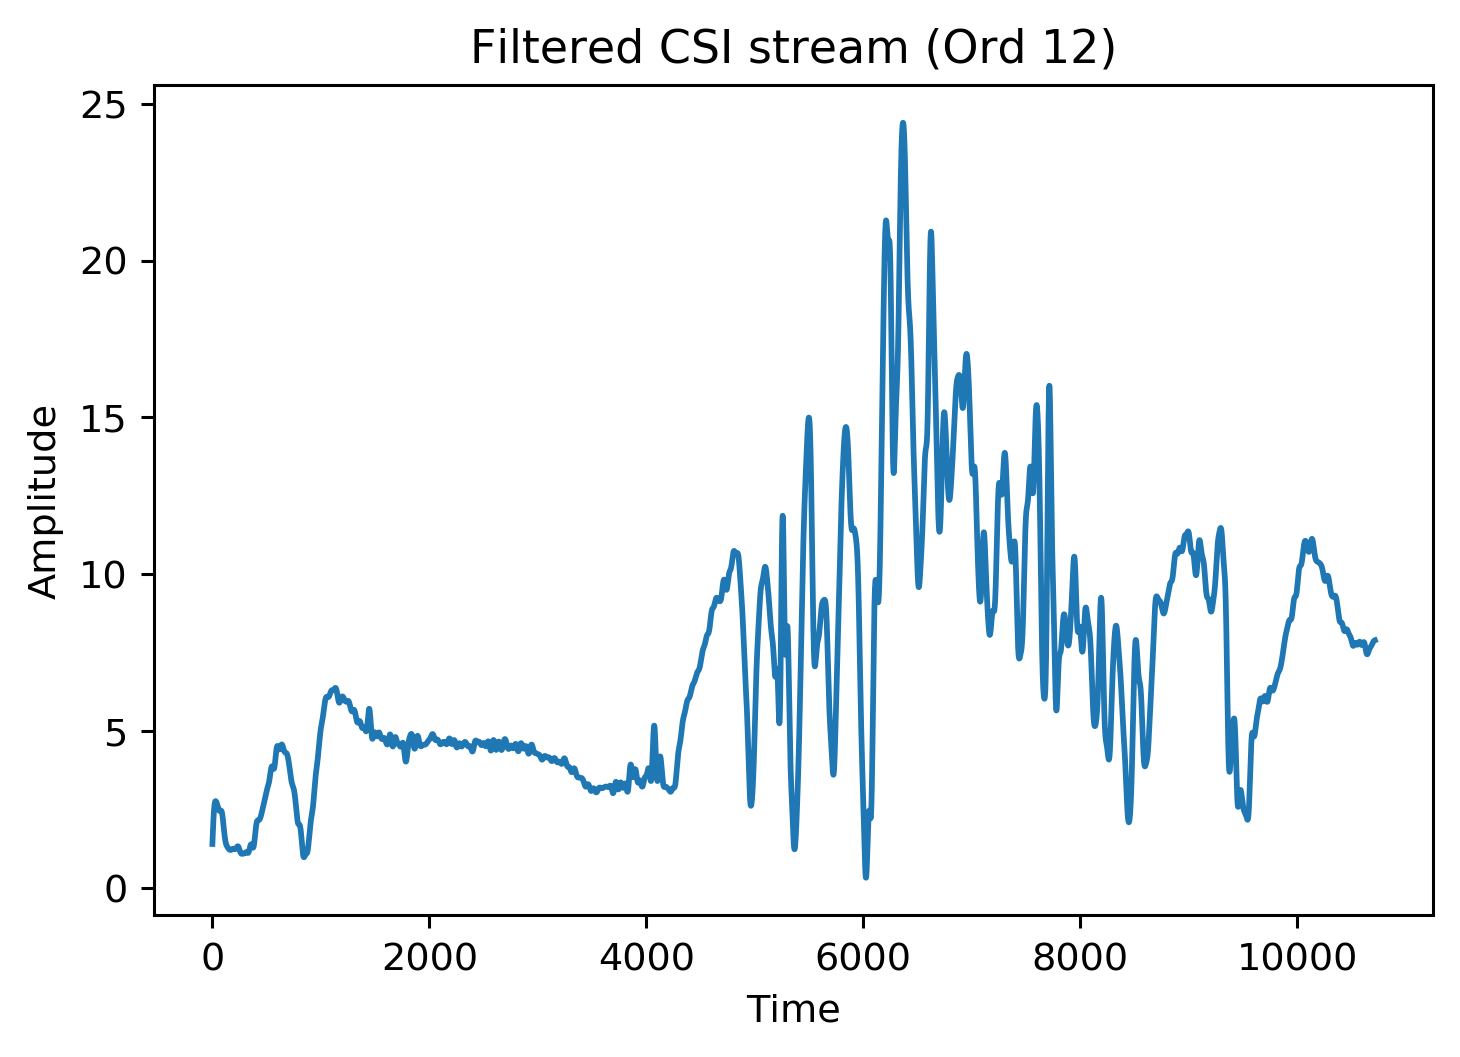

In [45]:
# Before Silence removal
plt.plot(output)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Filtered CSI stream (Ord 12)')

Text(0.5, 1.0, 'Filtered CSI stream (Ord 12) - Silence removed')

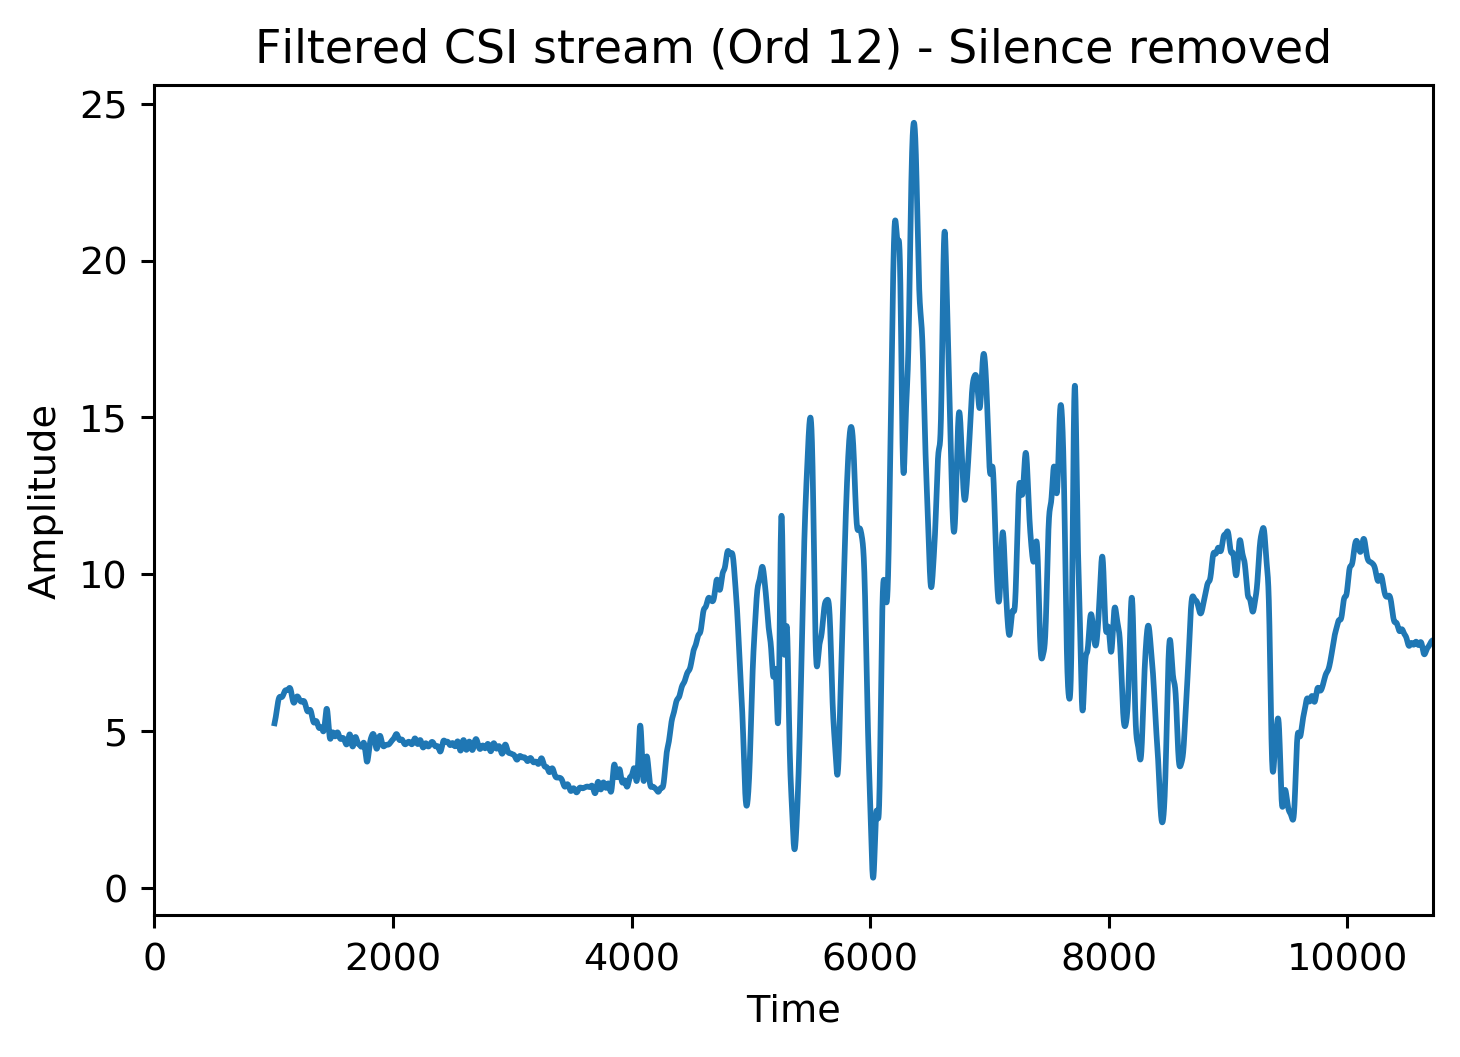

In [46]:
# Trimmed output is the CSI stream after silence has been removed.

trimmed_output = np.full(num_packets, np.nan)
trimmed_output[start_point:end_point] = output[start_point:end_point]

plt.plot(trimmed_output)
plt.xlim(left=0, right=num_packets)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Filtered CSI stream (Ord 12) - Silence removed')

In [47]:
# fs = 500    # The sampling rate
# nfft = 50   # Length of windowing segments
# plt.specgram(output, Fs=500, cmap='jet', NFFT=500, noverlap=50, scale_by_freq=True)#, xextent=(0,1.627))
# plt.margins(x=0, y=1)

In [48]:
# plt.specgram(trimmed_output, Fs=500, cmap='jet', NFFT=500, noverlap=50, scale_by_freq=True,)# xextent=(0,1.627))
